In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [165]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import math
import os

from sklearn import metrics, model_selection
from sklearn.preprocessing import scale, normalize
from sklearn import datasets, cluster
from sklearn import neighbors, ensemble, tree, linear_model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from hydra import initialize, compose

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    BatchNormalization,
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    Lambda,
    Softmax,
)

In [37]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

### Locate and choose config files

In [2]:
initialize('../src/conf/') # Assume the configuration file is in the current folder

hydra.initialize()

In [3]:
cfg = compose(config_name='train.yaml')

In [4]:
cfg.keys()

dict_keys(['project', 'segmentation_base_path', 'preprocessed_image_base_path', 'fourier_base_path', 'brixia_score_base_path', 'raw_output_base', 'img_size', 'backbone', 'last_dense_size', 'batch_size', 'epochs', 'learning_rate', 'steps_per_epoch', 'death_rate', 'visualize', 'augment', 'cross_val_train', 'n_folds', 'dataset_identifier', 'datasets'])

#### paths for image based models

In [5]:
cfg.preprocessed_image_base_path, cfg.fourier_base_path, cfg.segmentation_base_path

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/fourier_2d',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/segmented')

#### paths for dataframe based models

In [6]:
cfg.brixia_score_base_path

'/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/score_original'

In [7]:
cfg.datasets.keys()

dict_keys(['population_average', 'population_sampled', 'age_average', 'hospital_average'])

In [8]:
cfg.datasets.population_average.keys()

dict_keys(['train_table', 'valid_table', 'test_table', 'cv_train_table', 'cv_valid_table', 'feature_cols'])

##### read raw dataframe for future use if needed

In [300]:
whole_df = pd.read_excel('/mnt/ncshare/ai4covid_hackathon/raw_data/trainClinData.xls' )
raw_df = whole_df[ ['ImageFile', 'Prognosis'] ]
raw_df.Prognosis.replace('SEVERE', 1, inplace=True)
raw_df.Prognosis.replace('MILD', 0, inplace=True)
raw_df.head()

,ImageFile,Prognosis
0,P_102.png,1
1,P_131.png,0
2,P_132.png,0
3,P_117.png,0
4,P_16.png,1


##### how folds are encoded

In [9]:
cfg.datasets.population_average.cv_train_table, '+cv1.csv', '+cv2.csv', '...', '+cv5.csv'

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg_',
 '+cv1.csv',
 '+cv2.csv',
 '...',
 '+cv5.csv')

In [10]:
cfg.datasets.population_average.cv_valid_table

'/mnt/ncshare/ai4covid_hackathon/preprocessed_data/tables/pop_avg/validClinDataImputedPopAvg_'

##### train cv1 and valid cv1 are the corresponding parts

In [11]:
np.in1d( pd.read_csv( cfg.datasets.population_average.cv_train_table+'cv1.csv').ImageFile.unique(), pd.read_csv( cfg.datasets.population_average.cv_valid_table+'cv1.csv').ImageFile.unique() ).sum()

0

##### dataframe colums

In [12]:
best_cols = np.array(['Age', 'BPCO', 'CRP', 'CardiovascularDisease', 'Cough', 'D_dimer', 'DaysFever', 'Diabetes', 'DifficultyInBreathing', 'Fibrinogen', 'Glucose', 'HighBloodPressure', 'Hospital_A', 'Hospital_C', 'Hospital_D', 'Hospital_F', 'INR', 'IschemicHeartDisease', 'LDH', 'Ox_percentage', 'PCT', 'PaCO2', 'PaO2', 'Position', 'RBC', 'SaO2', 'Sex', 'Temp_C', 'WBC', 'pH'])

In [13]:
best_cols.shape

(30,)

In [14]:
np.array(cfg.datasets.population_average.feature_cols)[ np.in1d(cfg.datasets.population_average.feature_cols, best_cols) ]

array(['Age', 'Sex', 'Temp_C', 'DaysFever', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Fibrinogen',
       'Glucose', 'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2',
       'SaO2', 'PaCO2', 'pH', 'CardiovascularDisease',
       'IschemicHeartDisease', 'HighBloodPressure', 'Diabetes', 'BPCO',
       'Position', 'Hospital_A', 'Hospital_C', 'Hospital_D', 'Hospital_F'],
      dtype='<U21')

## Table based models

### Data preprocessing

In [231]:
def dataframe_preproc( df, columns=[] ):
    df.Prognosis.replace('SEVERE', 1, inplace=True)
    df.Prognosis.replace('MILD', 0, inplace=True)
    X_df = df.drop( columns=['ImageFile', 'Prognosis', 'Death'])    
    
    y = df[ ['Prognosis', 'Death'] ].values
        
    if len(columns) > 0:
        X_df = X_df[best_cols] # restrict to certain columns only
    
    X = X_df.values
    X_features = X_df.columns
        
    return X, y, X_features

In [148]:
def load_cv_data( cv=1, dataset='population_average', columns=[], include_death_column=False ):
    train_cv_df = pd.read_csv( cfg.datasets[dataset].cv_train_table+'cv'+str(cv)+'.csv')
    valid_cv_df = pd.read_csv( cfg.datasets[dataset].cv_valid_table+'cv'+str(cv)+'.csv')

    x_train, y_train, features_train = dataframe_preproc( train_cv_df, columns )
    x_valid, y_valid, features_valid = dataframe_preproc( valid_cv_df, columns )

    if include_death_column:
         return x_train, y_train, x_valid, y_valid
        
    else:
        # keep prognosis only
        y_train = y_train[:,0]
        y_valid = y_valid[:,0]

        #print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
        return x_train, y_train, x_valid, y_valid    

In [150]:
x_train, y_train, x_valid, y_valid = load_cv_data(1, 'population_average', columns=best_cols)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(882, 30) (882,) (221, 30) (221,)


### Sklearn models

In [18]:
def five_fold_cv_model_eval( model, dataset='population_average', columns=[]):
    try:
        model_instance = model(n_jobs=8)
    except:
        model_instance = model()
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    scores = {}
    
    for f in range(1,6):
        x_train, y_train, x_valid, y_valid = load_cv_data(f, dataset, columns)
        model_instance.fit(x_train, y_train)
        try:
            pred_values_label = model_instance.predict(x_valid)
            b_acc = metrics.balanced_accuracy_score( y_pred=pred_values_label, y_true=y_valid )
            f1 = metrics.f1_score( y_true=y_valid, y_pred=pred_values_label )
            f1s.append(f1)
            b_accs.append(b_acc)
        except:
            print('', end='\r')
        
        try:
            pred_values_proba = model_instance.predict_proba(x_valid)            
            roc_auc = metrics.roc_auc_score( y_true=y_valid, y_score=pred_values_proba[:,1] )
            roc_aucs.append(roc_auc)
            
        except:
            try:
                # this is added for SVM proba pred
                model_instance = model(probability=True)
                model_instance.fit(x_train, y_train)
                pred_values_proba = model_instance.predict_proba(x_valid)
                roc_auc = metrics.roc_auc_score( y_true=y_valid, y_score=pred_values_proba[:,1] )
                roc_aucs.append(roc_auc)
            except:
                print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    return scores

#### Define models

In [19]:
models_to_run = { 'Logistic': linear_model.LogisticRegression, 'SVM': svm.SVC, 
                  'Randomforest': ensemble.RandomForestClassifier, 'GradientBoosting': ensemble.GradientBoostingClassifier,
                  'XGB': XGBClassifier, }
models_to_run

{'Logistic': sklearn.linear_model._logistic.LogisticRegression,
 'SVM': sklearn.svm._classes.SVC,
 'Randomforest': sklearn.ensemble._forest.RandomForestClassifier,
 'GradientBoosting': sklearn.ensemble._gb.GradientBoostingClassifier,
 'XGB': xgboost.sklearn.XGBClassifier}

In [20]:
num_to_model = dict( zip( np.arange(len(models_to_run)), list(models_to_run.keys()) ) )
num_to_model

{0: 'Logistic', 1: 'SVM', 2: 'Randomforest', 3: 'GradientBoosting', 4: 'XGB'}

In [79]:
def legend_without_duplicate_labels(ax):
    # https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib/40870637
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [91]:
def fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='blue', m='o', shift=0, columns=[]):
    for i in range( len(num_to_model) ):
        current_model = num_to_model[i] 
        #print(current_model)
        scores = five_fold_cv_model_eval( models_to_run[current_model], dataset, columns )

        ax1 = plt.subplot(131)
        value = np.mean( scores['balanced_accuracy'] )
        std_err = np.std( scores['balanced_accuracy'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['balanced_accuracy'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45 )
        plt.ylabel('Balanced accuracy score')
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax1)        

        ax2 = plt.subplot(132)
        value = np.mean( scores['roc_auc'] )
        std_err = np.std( scores['roc_auc'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['roc_auc'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45)
        plt.ylabel('Roc auc score')
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax2)        

        ax3 = plt.subplot(133)
        value = np.mean( scores['f1'] )
        std_err = np.std( scores['f1'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['f1'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45 )
        plt.ylabel('F1 score')
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax3)

[15:13:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

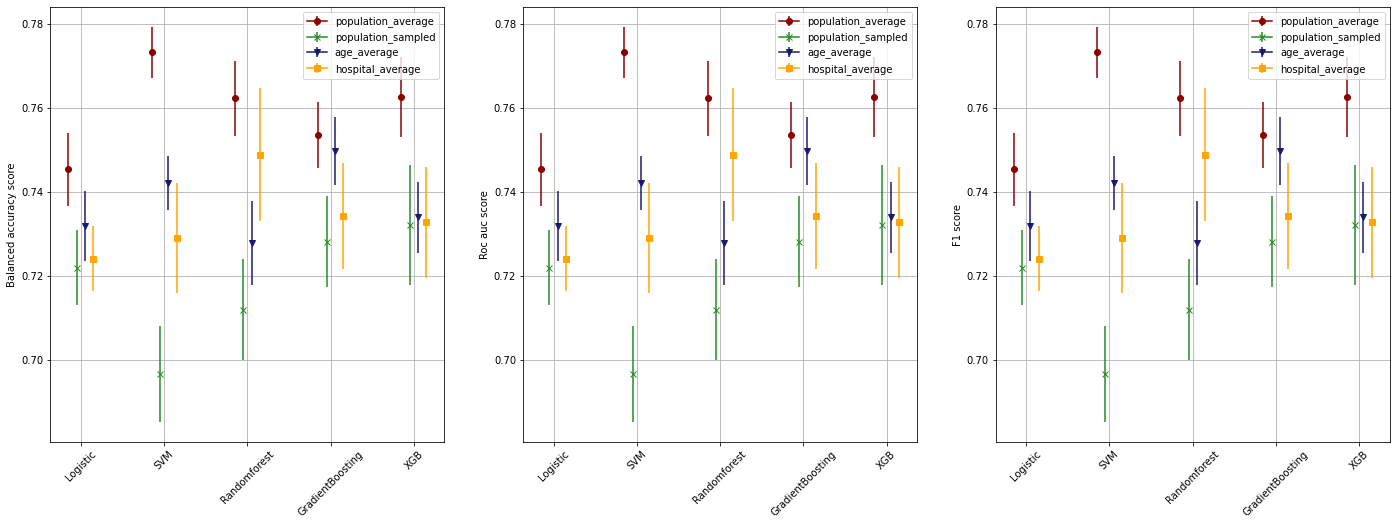

In [92]:
fig = plt.figure( figsize=(24,8) )
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='darkred', m='o', shift=-0.15)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='age_average', color='midnightblue', m='v', shift=0.05)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='hospital_average', color='orange', m='s', shift=0.15)

##### only best features

In [97]:
best_cols, best_cols.shape

(array(['Age', 'BPCO', 'CRP', 'CardiovascularDisease', 'Cough', 'D_dimer',
        'DaysFever', 'Diabetes', 'DifficultyInBreathing', 'Fibrinogen',
        'Glucose', 'HighBloodPressure', 'Hospital_A', 'Hospital_C',
        'Hospital_D', 'Hospital_F', 'INR', 'IschemicHeartDisease', 'LDH',
        'Ox_percentage', 'PCT', 'PaCO2', 'PaO2', 'Position', 'RBC', 'SaO2',
        'Sex', 'Temp_C', 'WBC', 'pH'], dtype='<U21'),
 (30,))

[15:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

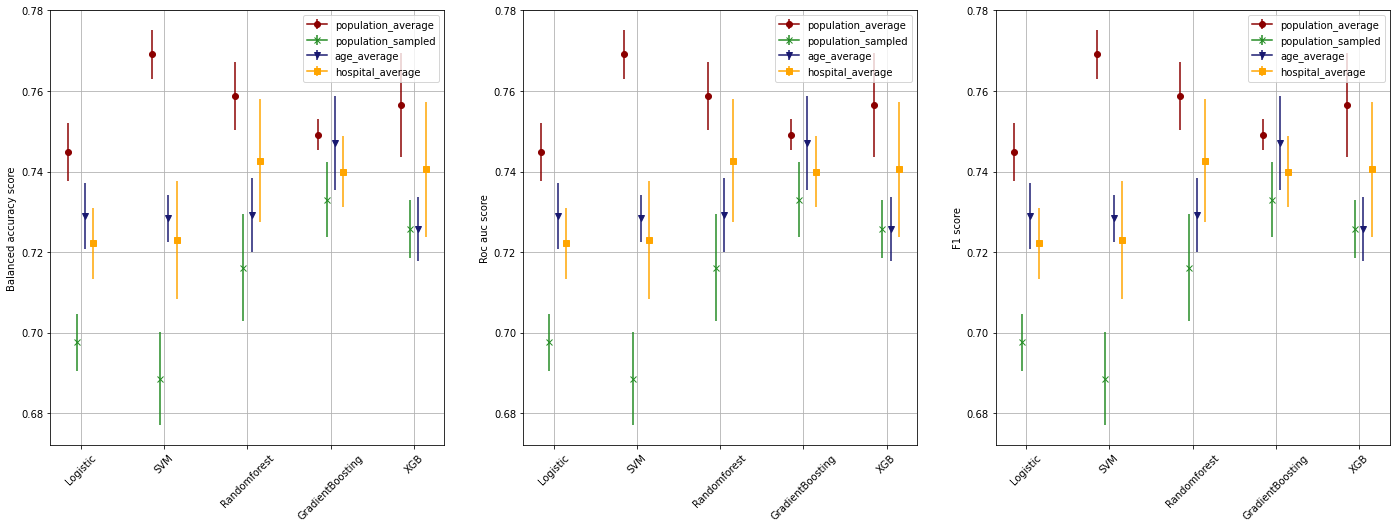

In [94]:
fig = plt.figure( figsize=(24,8) )
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='darkred', m='o', shift=-0.15, columns=best_cols)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05, columns=best_cols)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='age_average', color='midnightblue', m='v', shift=0.05, columns=best_cols)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='hospital_average', color='orange', m='s', shift=0.15, columns=best_cols)

## Simple neural networks

In [98]:
cfg.preprocessed_image_base_path, cfg.fourier_base_path, cfg.segmentation_base_path

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/fourier_2d',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/segmented')

In [96]:
x_train, y_train, x_valid, y_valid = load_cv_data(1, 'population_average', columns=best_cols, include_death_column=True)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((882, 30), (882, 2), (221, 30), (221, 2))

In [118]:
def meta_model( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(64, activation="relu")(input_meta)
    meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(128, activation="relu")(meta)
    meta = BatchNormalization(name="meta_bn2")(meta)
    meta = Dense(256, activation="relu")(meta)
    meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(256, activation="relu")(meta_out)
    out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(out)
    out = Dense(cfg.last_dense_size, activation="relu")(out)
    out = BatchNormalization(name="head_bn2")(out)
    out = Dense(4, activation="linear", name="unnormalized_output")(out)

    p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
        out
    )
    prognosis_out = Softmax(name="prognosis_out")(p)
    death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[prognosis_out, death_out],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        cfg.learning_rate,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=0.15,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=5,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy)

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model

In [151]:
def five_fold_cv_model_eval_NN( model, dataset='population_average', columns=[]):
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    scores = {}
    
    for f in range(1,6):
        #print(columns)
        x_train, y_train, x_valid, y_valid = load_cv_data(f, dataset, columns, include_death_column=True)
        #print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
        model_instance = model(x_train.shape[1]) # init with feature
        
        
        history = model_instance.fit( x=x_train, y=[ tf.keras.utils.to_categorical(y_train[:,0]), tf.keras.utils.to_categorical(y_train[:,1]) ],
                            validation_data=( x_valid, [ tf.keras.utils.to_categorical(y_valid[:,0]), tf.keras.utils.to_categorical(y_valid[:,1]) ] ),
                            epochs=cfg.epochs,
                            callbacks=[early_stopping],
                            verbose=0,
                            )
        prognosis_pred, death_pred = model_instance.predict( x_valid )
        
        prognosis_pred_labels = np.argmax( prognosis_pred, axis=-1)
        prognosis_pred_proba = prognosis_pred[:,1]
        #print(prognosis_pred_labels.shape, prognosis_pred_labels[:5], y_valid[:5])
        
        try:
            b_acc = metrics.balanced_accuracy_score( y_pred=prognosis_pred_labels, y_true=y_valid[:,0] )
            f1 = metrics.f1_score( y_true=y_valid[:,0], y_pred=prognosis_pred_labels )
            f1s.append(f1)
            b_accs.append(b_acc)
        except:
            print('', end='\r')
        
        try:
            roc_auc = metrics.roc_auc_score( y_true=y_valid[:,0], y_score=prognosis_pred_proba )
            roc_aucs.append(roc_auc)
            
        except:
            print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    return scores

In [152]:
models_to_run_NN = { 'meta_base': meta_model }
num_to_model_NN = dict( zip( np.arange(len(models_to_run_NN)), list(models_to_run_NN.keys()) ) )
models_to_run_NN, num_to_model_NN

({'meta_base': <function __main__.meta_model(n_feature_cols)>},
 {0: 'meta_base'})

In [153]:
def fit_and_eval_models_NN( num_to_model, models_to_run, five_fold_cv_model_eval, fig, 
                            dataset='population_average', color='blue', m='o', shift=0, columns=[]):
    for i in range( len(num_to_model) ):
        current_model = num_to_model[i] 
        print(current_model)
        scores = five_fold_cv_model_eval( models_to_run[current_model], dataset, columns )

        ax1 = plt.subplot(131)
        value = np.mean( scores['balanced_accuracy'] )
        std_err = np.std( scores['balanced_accuracy'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['balanced_accuracy'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45 )
        plt.ylabel('Balanced accuracy score')
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax1)        

        ax2 = plt.subplot(132)
        value = np.mean( scores['roc_auc'] )
        std_err = np.std( scores['roc_auc'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['roc_auc'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45)
        plt.ylabel('Roc auc score')
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax2)        

        ax3 = plt.subplot(133)
        value = np.mean( scores['f1'] )
        std_err = np.std( scores['f1'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['f1'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45 )
        plt.ylabel('F1 score')
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax3)

meta_base
meta_base
meta_base
meta_base


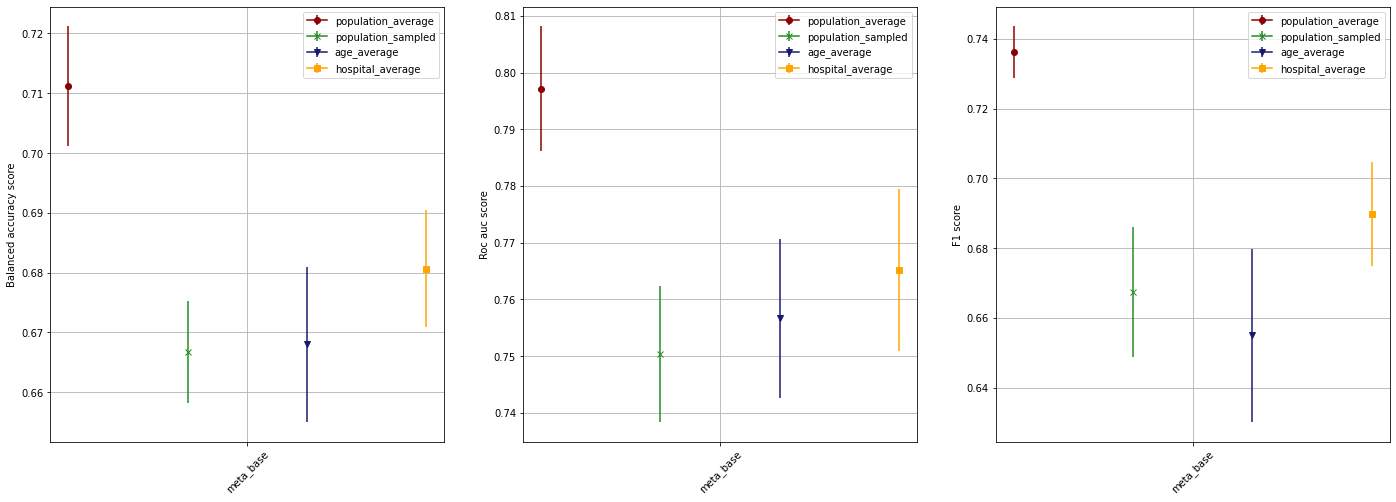

In [154]:
fig = plt.figure( figsize=(24,8) )
fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, five_fold_cv_model_eval_NN, fig, dataset='population_average', color='darkred', m='o', shift=-0.15)
fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, five_fold_cv_model_eval_NN, fig, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05)
fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, five_fold_cv_model_eval_NN, fig, dataset='age_average', color='midnightblue', m='v', shift=0.05)
fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, five_fold_cv_model_eval_NN, fig, dataset='hospital_average', color='orange', m='s', shift=0.15)

## More complex model

#### Locate data

In [301]:
!ls ../data/raw_output/

attentions	  checkpoints		  checkpoints_xplainable
batch_sample.png  checkpoints_image_only


In [302]:
base_path = os.path.join( cfg.raw_output_base, 'checkpoints' )
model_cross_val_paths = np.array( sorted( [ i for i in os.listdir( base_path ) if 'CROSS' in i] ) )
model_datasets = np.array([ '_'.join( j.split('_')[2:4]) for j in model_cross_val_paths ])
base_path, model_cross_val_paths, model_datasets

('/mnt/ncshare/ai4covid_hackathon/raw_output/checkpoints',
 array(['CROSS_VAL_age_average_v1', 'CROSS_VAL_pop_average_v1'],
       dtype='<U24'),
 array(['age_average', 'pop_average'], dtype='<U11'))

In [303]:
current_fold_path = os.path.join( base_path, cross_val_paths[0] )
model_checkpoint_dir = os.listdir( current_fold_path )
model_checkpoint_dir

['2022-02-28_13:01:52.829394',
 '2022-02-28_13:08:37.211034',
 '2022-02-28_13:02:04.704448',
 '2022-02-28_13:01:00.165300',
 '2022-02-28_13:01:33.781056']

In [304]:
current_final_path = os.path.join( current_fold_path, model_checkpoint_dir[0] )+ '/pred.csv'
current_final_path

'/mnt/ncshare/ai4covid_hackathon/raw_output/checkpoints/CROSS_VAL_age_average_v1/2022-02-28_13:01:52.829394/pred.csv'

### THE FOLDS ARE NOT ALIGNED!

In [305]:
np.in1d( pd.read_csv(current_final_path).file.unique(), pd.read_csv( cfg.datasets.population_average.cv_valid_table+'cv1.csv').ImageFile.unique() ).sum()

33

In [313]:
np.in1d( raw_df.ImageFile.unique(), pd.read_csv(current_final_path).file.unique() ).sum()

221

In [310]:
pd.read_csv(current_final_path).file.unique().shape

(221,)

In [392]:
def load_cv_data_pred_only( cv=1, dataset='age_average' ):
    
    base_path = os.path.join( cfg.raw_output_base, 'checkpoints' )
    model_cross_val_paths = np.array( sorted( [ i for i in os.listdir( base_path ) if 'CROSS' in i] ) )
    model_datasets = np.array([ '_'.join( j.split('_')[2:4]) for j in model_cross_val_paths ])
    #print(base_path, model_cross_val_paths,'dataset', model_datasets)
    #print('EHERE', model_cross_val_paths[ model_datasets == dataset ][0] )
    cross_val_paths = model_cross_val_paths[ model_datasets == dataset ]
    #print('cross_', cross_val_paths)
    
    current_fold_path = os.path.join( base_path, cross_val_paths[0] )
    model_checkpoint_dir = os.listdir( current_fold_path )
    #print(model_checkpoint_dir)
    
    current_final_path = os.path.join( current_fold_path, model_checkpoint_dir[cv-1] )+ '/pred.csv'
    #print(current_final_path)
    
    pred_df = pd.read_csv(current_final_path)
    pred_df.prognosis.replace('SEVERE', 1, inplace=True)
    pred_df.prognosis.replace('MILD', 0, inplace=True)
    
    y_pred = pred_df.prognosis.values
    y_true = raw_df.Prognosis[ np.in1d( raw_df.ImageFile, pred_df.file ) ].values
        
    return y_pred, y_true

In [393]:
def five_fold_cv_model_eval_NN_pred_only(dataset='age_average'):
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    scores = {}
    
    for f in range(1,6):
        #print(columns)
        y_pred, y_true = load_cv_data_pred_only(f, dataset)
        
        try:
            b_acc = metrics.balanced_accuracy_score( y_pred=y_pred, y_true=y_true )
            f1 = metrics.f1_score( y_true=y_true, y_pred=y_pred )
            f1s.append(f1)
            b_accs.append(b_acc)
        except:
            print('', end='\r')
        
        try:
            roc_auc = metrics.roc_auc_score( y_true=y_true, y_score=y_pred )
            roc_aucs.append(roc_auc)
            
        except:
            print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    return scores

In [395]:
five_fold_cv_model_eval_NN_pred_only('age_average')

{'balanced_accuracy': [0.5193763370083924,
  0.5026233808821118,
  0.5253605375286792,
  0.52188013136289,
  0.5434693543100623],
 'roc_auc': [0.5193763370083924,
  0.5026233808821118,
  0.5253605375286791,
  0.52188013136289,
  0.5434693543100624],
 'f1': [0.5431034482758621,
  0.4999999999999999,
  0.5291479820627802,
  0.5181818181818182,
  0.5388127853881279]}

In [394]:
five_fold_cv_model_eval_NN_pred_only('pop_average')

{'balanced_accuracy': [0.503595041322314,
  0.4750491642084562,
  0.48791379875450674,
  0.49252136752136755,
  0.49642093138061544],
 'roc_auc': [0.503595041322314,
  0.4750491642084562,
  0.4879137987545068,
  0.49252136752136755,
  0.49642093138061544],
 'f1': [0.5439330543933053,
  0.46788990825688076,
  0.5108225108225107,
  0.5506072874493927,
  0.48623853211009177]}

In [ ]:
eddigi kódok ellenőrzése, futtatása, tesztelése

kiértékelés összehasonlítása, mindegyik ugyanazon az adatrészen és ugyanazzal a metrikával

## From before

### Read folds

In [5]:
imputed_data_age_average = pd.read_csv('../data/preprocessed_data/tables/age_avg/trainClinDataImputedAgeAvg.csv')
imputed_data_age_average['Prognosis'] = imputed_data_age_average['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)
cols_top_drop = ['Prognosis', 'Death', 'ImageFile']

In [68]:
trainClinDataImputedAgeAvg_cv1 = pd.read_csv('../data/preprocessed_data/tables/age_avg/trainClinDataImputedAgeAvg_cv1.csv')
trainClinDataImputedAgeAvg_cv2 = pd.read_csv('../data/preprocessed_data/tables/age_avg/trainClinDataImputedAgeAvg_cv2.csv')
trainClinDataImputedAgeAvg_cv3 = pd.read_csv('../data/preprocessed_data/tables/age_avg/trainClinDataImputedAgeAvg_cv3.csv')
trainClinDataImputedAgeAvg_cv4 = pd.read_csv('../data/preprocessed_data/tables/age_avg/trainClinDataImputedAgeAvg_cv4.csv')
trainClinDataImputedAgeAvg_cv5 = pd.read_csv('../data/preprocessed_data/tables/age_avg/trainClinDataImputedAgeAvg_cv5.csv')

validClinDataImputedAgeAvg_cv1 = pd.read_csv('../data/preprocessed_data/tables/age_avg/validClinDataImputedAgeAvg_cv1.csv')
validClinDataImputedAgeAvg_cv2 = pd.read_csv('../data/preprocessed_data/tables/age_avg/validClinDataImputedAgeAvg_cv2.csv')
validClinDataImputedAgeAvg_cv3 = pd.read_csv('../data/preprocessed_data/tables/age_avg/validClinDataImputedAgeAvg_cv3.csv')
validClinDataImputedAgeAvg_cv4 = pd.read_csv('../data/preprocessed_data/tables/age_avg/validClinDataImputedAgeAvg_cv4.csv')
validClinDataImputedAgeAvg_cv5 = pd.read_csv('../data/preprocessed_data/tables/age_avg/validClinDataImputedAgeAvg_cv5.csv')

In [47]:
def get_explanining_variables( selector, original_feature_columns, X_test, y_test ):
    return sorted( original_feature_columns[selector.support_].values.tolist() ),\
           selector.score(X_test, y_test),\
           selector.predict(X_test)

In [48]:
def do_rfe_with_cv( regressor, X, y, n_features_to_select=20 ):
    rfe = RFE( estimator=regressor, n_features_to_select=n_features_to_select, step=1 )
    rfe = rfe.fit(X, y)
    return rfe

In [49]:
X_train, X_test, y_train, y_test = train_test_split( imputed_data_age_average.drop(cols_top_drop, axis=1), imputed_data_age_average['Prognosis'], test_size=.1, random_state=42 )

In [56]:
exp_logi, logi_test_score, logi_preds = get_explanining_variables(
    do_rfe_with_cv(ensemble.RandomForestClassifier(), X_train, y_train, n_features_to_select=30),
                    imputed_data_age_average.drop(cols_top_drop, axis=1).columns, X_test, y_test)
exp_logi

['Age',
 'BPCO',
 'CRP',
 'CardiovascularDisease',
 'Cough',
 'D_dimer',
 'DaysFever',
 'Diabetes',
 'DifficultyInBreathing',
 'Fibrinogen',
 'Glucose',
 'HighBloodPressure',
 'Hospital_A',
 'Hospital_C',
 'Hospital_D',
 'Hospital_F',
 'INR',
 'IschemicHeartDisease',
 'LDH',
 'Ox_percentage',
 'PCT',
 'PaCO2',
 'PaO2',
 'Position',
 'RBC',
 'SaO2',
 'Sex',
 'Temp_C',
 'WBC',
 'pH']

### Calculating metrics

In [58]:

#init models
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=10, objective='binary:logistic', use_label_encoder=False)


#CV
#cols_to_keep = ['Age', 'CRP', 'ChronicKidneyDisease', 'Diabetes', 'DifficultyInBreathing', 'Hospital_A', 'Hospital_B', 'Hospital_C', 'Hospital_D', 'Hospital_E', 'Hospital_F', 'Ictus', 'LDH', 'Obesity', 'Ox_percentage', 'PCT', 'Position', 'PositivityAtAdmission', 'SaO2', 'Sex']
cols_to_keep = ['Age',
 'BPCO',
 'CRP',
 'CardiovascularDisease',
 'Cough',
 'D_dimer',
 'DaysFever',
 'Diabetes',
 'DifficultyInBreathing',
 'Fibrinogen',
 'Glucose',
 'HighBloodPressure',
 'Hospital_A',
 'Hospital_C',
 'Hospital_D',
 'Hospital_F',
 'INR',
 'IschemicHeartDisease',
 'LDH',
 'Ox_percentage',
 'PCT',
 'PaCO2',
 'PaO2',
 'Position',
 'RBC',
 'SaO2',
 'Sex',
 'Temp_C',
 'WBC',
 'pH']
rf_preds   = model_selection.cross_val_predict(rf, imputed_data_age_average[cols_to_keep], imputed_data_age_average['Prognosis'], method='predict', cv=5)
tree_preds = model_selection.cross_val_predict(dt, imputed_data_age_average[cols_to_keep], imputed_data_age_average['Prognosis'], method='predict', cv=5)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data_age_average[cols_to_keep], imputed_data_age_average['Prognosis'], method='predict', cv=5)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data_age_average[cols_to_keep], imputed_data_age_average['Prognosis'], method='predict', cv=5)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data_age_average[cols_to_keep], imputed_data_age_average['Prognosis'], method='predict', cv=5)

balanced_accuracy_all_list = []
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    balanced_accuracy = np.round(metrics.balanced_accuracy_score(y_pred=preds, y_true=imputed_data_age_average['Prognosis']), 3)
    balanced_accuracy_all_list.append(balanced_accuracy)
    
balanced_accuracy_all = pd.DataFrame(np.array(balanced_accuracy_all_list).reshape(1,-1), columns=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'])
balanced_accuracy_all

[17:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,random forest,decision tree,logistic_regression,knn,xgb
0,0.736,0.628,0.728,0.67,0.719


In [70]:

random forest	decision tree	logistic_regression	knn	xgb
0	0.747	0.671	0.73	0.698	0.744

SyntaxError: invalid syntax (2383861795.py, line 1)

In [90]:
# check on folds from janos server

In [93]:
rf_preds   = ensemble.RandomForestClassifier(random_state=42).fit(trainClinDataImputedAgeAvg_cv3.drop(cols_top_drop, axis=1), trainClinDataImputedAgeAvg_cv3['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)).predict(validClinDataImputedAgeAvg_cv3.drop(cols_top_drop, axis=1))

In [94]:
balanced_accuracy = np.round(metrics.balanced_accuracy_score(y_pred=rf_preds, y_true=validClinDataImputedAgeAvg_cv3['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
balanced_accuracy

0.746